In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import pmdarima as pm

In [2]:
print("Loading data file now, this could take a while depending on file size")
start = time.time()
df = pd.read_csv('../ex08/ABRT.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading data file now, this could take a while depending on file size
Loading took 0.02 seconds


In [3]:
df['temp'][df['temp'] < 0] = 0 # ทำให้ค่าที่ต่ำกว่า 0 มีค่า 0

C:\Users\singk\AppData\Local\Temp\ipykernel_2484\2459940582.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['temp'][df['temp'] < 0] = 0 # ทำให้ค่าที่ต่ำกว่า 0 มีค่า 0
C:\Users\singk\AppData\Local\Temp\ipykernel_2484\2459940582.py:1: S

In [4]:
df['data_time'] = pd.to_datetime(df['date'] + ' ' + df['time']) #รวมวันและเวลา
df = df.drop(columns=['date', 'time'])

In [5]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.set_index('data_time')

In [6]:
result = df_cleaned[df_cleaned['temp'] == 0]

In [7]:
result.head()

,temp
data_time,
2012-01-01 00:00:00,0.0
2012-01-01 01:00:00,0.0
2012-01-01 02:00:00,0.0
2012-01-01 04:00:00,0.0
2012-01-01 05:00:00,0.0


In [8]:
df_cleaned = df_cleaned["2012-01-13 14:00:00":"2012-01-30 23:00:00"]

In [10]:
Current_data = len(df_cleaned)/len(df) *100

data_loss = 100 - Current_data

f"data_loss {data_loss:.3f} % ____ Current_data {Current_data:.3f} %"

'data_loss 43.817 % ____ Current_data 56.183 %'

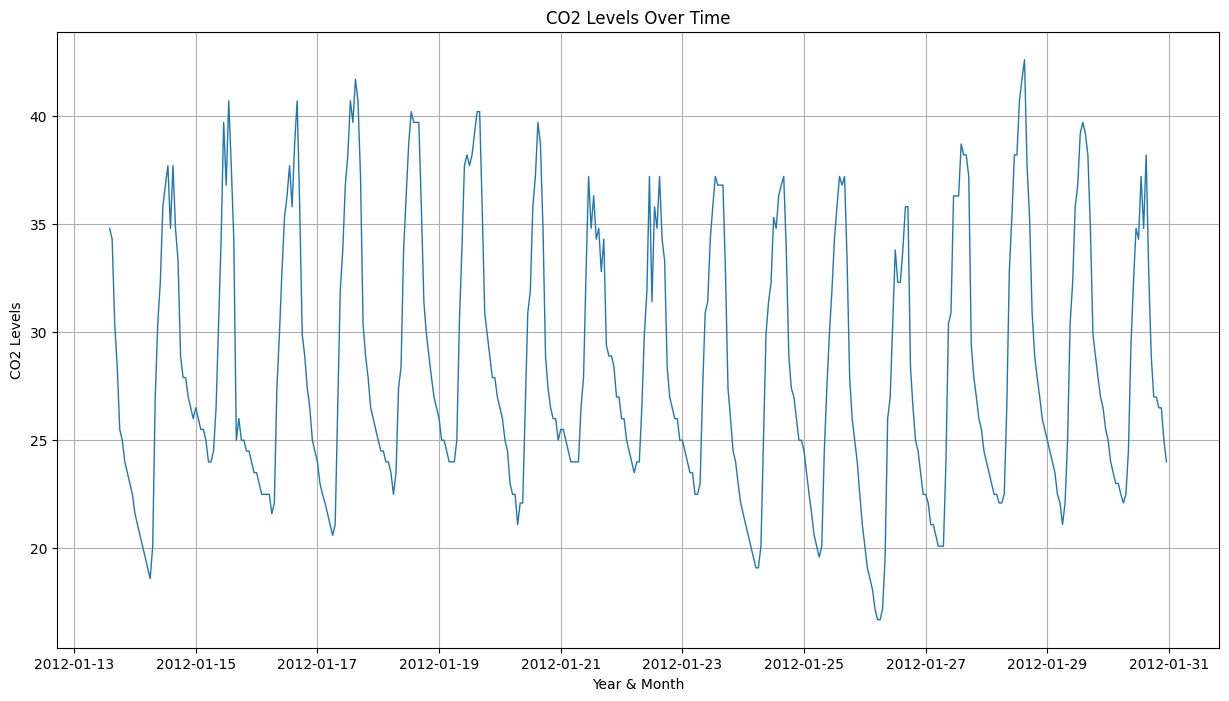

In [11]:
# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(df_cleaned['temp'] ,label='temp',linewidth=1)
# Add labels and title
plt.xlabel('Year & Month')
plt.ylabel('CO2 Levels')
plt.title('CO2 Levels Over Time')
# Show the plot
plt.grid(True)
plt.show()

# Train_test_data

In [12]:
train_start_dt = '2012-01-13 14:00:00'
test_start_dt = '2012-01-27 23:00:00'

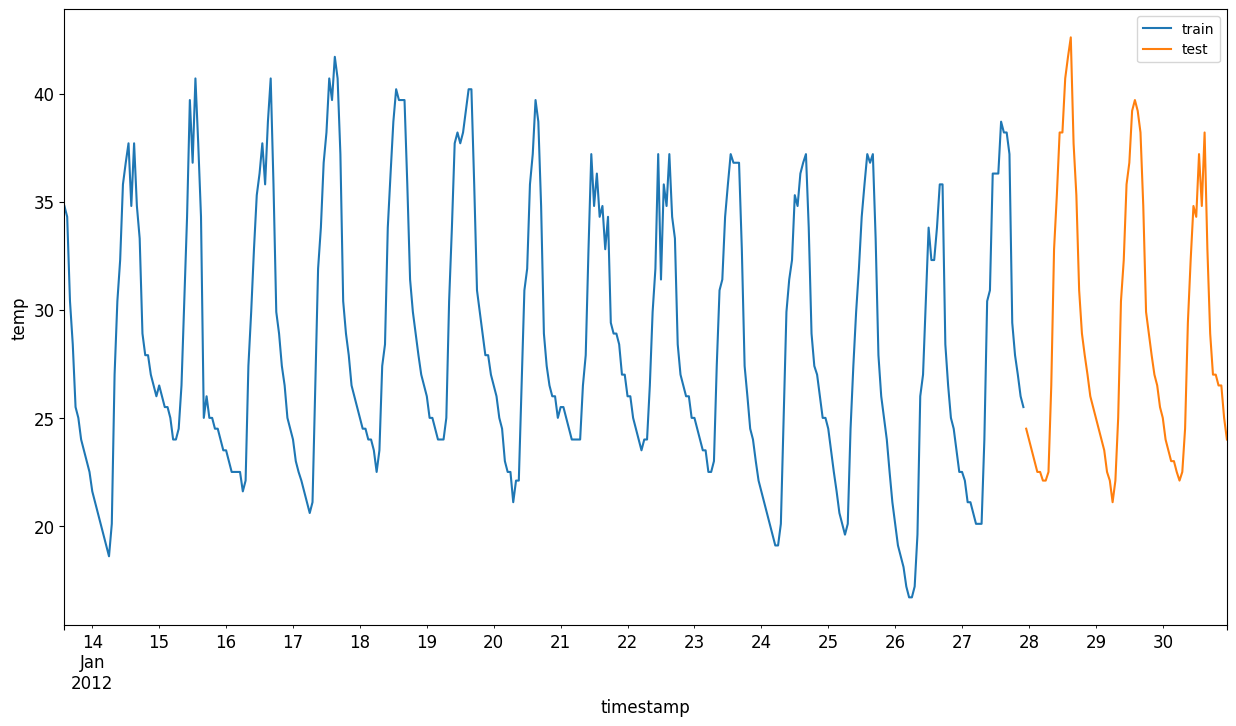

In [13]:
df_cleaned[(df_cleaned.index < test_start_dt) & (df_cleaned.index >= train_start_dt)] [['temp']].rename(columns={'temp':'train'}) \
    .join(df_cleaned[test_start_dt:][['temp']].rename(columns={'temp':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('temp', fontsize=12)
plt.show()

In [14]:
train = df_cleaned.copy()[(df_cleaned.index >= train_start_dt) & (df_cleaned.index < test_start_dt)][['temp']]
test = df_cleaned.copy()[df_cleaned.index >= test_start_dt][['temp']]

In [15]:
print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (345, 1)
Test data shape:  (73, 1)


In [16]:
train.index = pd.to_datetime(train.index) # เอาให้แน่ใจว่า index คือ datetime
train.index.freq = 'h' # ปลับเลือกความถี่ 

In [17]:
train

,temp
data_time,
2012-01-13 14:00:00,34.8
2012-01-13 15:00:00,34.3
2012-01-13 16:00:00,30.4
2012-01-13 17:00:00,28.4
2012-01-13 18:00:00,25.5
...,...
2012-01-27 18:00:00,29.4
2012-01-27 19:00:00,27.9
2012-01-27 20:00:00,27.0


In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm  
from statsmodels.tsa.arima.model import ARIMA

In [24]:


# กำหนดช่วงของพารามิเตอร์
p = d = q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

# ค้นหาพารามิเตอร์ที่ดีที่สุด
best_aic = float("inf")
best_params = None
best_seasonal_params = None

# ใช้ tqdm เพื่อแสดงแถบความก้าวหน้า
for param in tqdm(itertools.product(p, d, q), desc="Fitting ARIMA parameters"):
    for seasonal_param in tqdm(seasonal_pdq, desc="Fitting Seasonal parameters", leave=False):
        try:
            model = SARIMAX(train,
                             order=param,
                             seasonal_order=seasonal_param,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
            results = model.fit(maxiter=200, disp=0)
            
            # บันทึกพารามิเตอร์ที่ดีที่สุด
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = seasonal_param

        except Exception as e:
            print(f"ARIMA{param}x{seasonal_param} - AIC: None - Exception: {e}")

# แสดงผลลัพธ์
if best_params is not None:
    print(f"Best SARIMA parameters: {best_params}")
    print(f"Best Seasonal parameters: {best_seasonal_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable model was found.")


Fitting ARIMA parameters: 0it [01:18, ?it/s]


KeyboardInterrupt: 

In [19]:


# กำหนดช่วงของพารามิเตอร์
p = d = q = range(0, 3)
best_aic = float("inf")
best_params = None

# ใช้ tqdm เพื่อแสดงแถบความก้าวหน้า
for param in tqdm(itertools.product(p, d, q), desc="Fitting ARIMA parameters"):
    try:
        model = ARIMA(train, order=param)
        results = model.fit()

        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param

    except Exception as e:
        print(f"ARIMA{param} - AIC: None - Exception: {e}")
        continue

if best_params is not None:
    print(f"Best ARIMA parameters: {best_params}")
    print(f"Best AIC: {best_aic}")
else:
    print("No suitable model was found.")


Fitting ARIMA parameters: 0it [00:00, ?it/s]C:\Users\singk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Fitting ARIMA parameters: 2it [00:00, 17.70it/s]C:\Users\singk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Fitting ARIMA parameters: 24it [00:01, 16.29it/s]C:\Users\singk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-

Best ARIMA parameters: (2, 0, 1)
Best AIC: 1414.2013706210942


In [20]:
SARIMAX_model = pm.auto_arima(train,
                           start_p=1, 
                           start_q=1,
                           test='adf',  # ใช้ ADF test เพื่อหา d
                           max_p=3, # ปรับเปลี่ยนตามความซับซ้อนของข้อมูล
                           max_q=3, # คล้ายกับ max_p ปรับเปลี่ยนให้เข้ากับข้อมูลเพื่อเพิ่มความสามารถของโมเดลในการคำนวณความผิดพลาด
                           m=24,  # m คือ seasonality (12 สำหรับข้อมูลรายเดือน)
                           start_P=0, # เริ่มต้นที่ 0 แต่สามารถเปลี่ยนได้ถ้าคุณเชื่อว่ามีอิทธิพลจากฤดูกาลในช่วงก่อนหน้า
                           seasonal=True,
                           d=None, # None
                           D=1,  # ให้ auto_arima ค้นหา d ที่เหมาะสม
                           trace=True, # ติดตามความก้าวหน้าในการสร้างโมเดล
                           error_action='ignore', # แสดงเตือนเมื่อเกิดข้อผิดพลาด 
                           suppress_warnings=True, # แสดงข้อความเตือนในระหว่างการทำงาน
                           stepwise=True) # True

# ดูค่าที่ auto_arima คำนวณได้
SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[24] intercept   : AIC=1140.715, Time=1.66 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=1608.945, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=1171.235, Time=1.16 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=1315.304, Time=1.41 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=1607.527, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=1252.094, Time=0.14 sec
 ARIMA(1,0,1)(1,1,1)[24] intercept   : AIC=1142.154, Time=2.30 sec
 ARIMA(1,0,1)(0,1,2)[24] intercept   : AIC=1142.302, Time=17.17 sec
 ARIMA(1,0,1)(1,1,0)[24] intercept   : AIC=1173.220, Time=1.33 sec
 ARIMA(1,0,1)(1,1,2)[24] intercept   : AIC=inf, Time=44.81 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=1139.037, Time=1.24 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=1253.411, Time=0.14 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=1140.284, Time=1.96 sec
 ARIMA(1,0,0)(0,1,2)[24] intercept   : AIC=1140.473, Time=14.21 sec
 ARIMA(1,0,0)(1,1,2)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  345
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 24)   Log Likelihood                -562.922
Date:                            Wed, 25 Sep 2024   AIC                           1135.844
Time:                                    11:14:08   BIC                           1154.701
Sample:                                01-13-2012   HQIC                          1143.373
                                     - 01-27-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0940      0.110     -0.851      0.395      -0.310       0.122
ar.L2          0.7863      0.090      8.705      0.000       0.609       0.963
ma.L1          0.8873      0.120      7.404      0.000       0.652       1.122
ma.S.L24      -0.7290      0.043    -17.030      0.000      -0.813      -0.645
sigma2         1.8396      0.100     18.316      0.000       1.643       2.037
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               324.98
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model = SARIMAX(train, order=(2,0, 1), seasonal_order=(0, 1, 1, 24))
model = model.fit(disp=1)

In [40]:
n = 73

In [35]:
prediction = model.get_forecast(steps=n)

In [36]:
prediction_index = test.index

In [37]:
# ค่าที่คาดการณ์
predicted = prediction.predicted_mean
# กรอบความเชื่อมั่น
confidence_intervals = prediction.conf_int(alpha=0.40)

In [38]:
test_values = np.array(test)  # Replace with your actual test values
predicted_values = np.array(predicted)
mape = np.mean(np.abs((test_values - predicted_values) / test_values)) * 100

MAPE: 23.47%


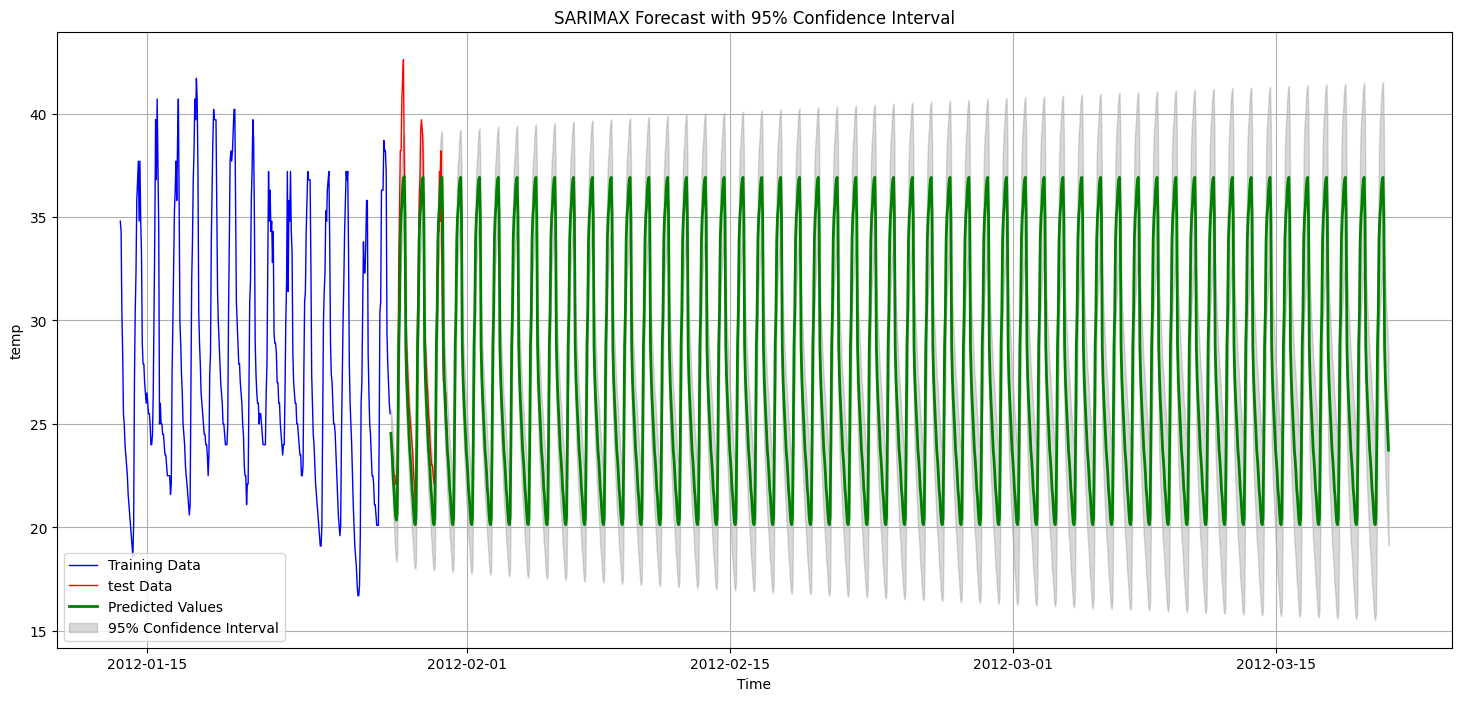

In [39]:
# สร้างกราฟ
print(f'MAPE: {mape:.2f}%')
plt.figure(figsize=(18, 8))
plt.plot( train, label='Training Data', color='blue',linewidth=1)  # ข้อมูลที่ใช้ฝึก
plt.plot( test, label='test Data', color='red',linewidth=1)
plt.plot( predicted, label='Predicted Values',color ='green',linewidth=2)  # ค่าที่คาดการณ์

# กรอบความเชื่อมั่น
plt.fill_between(predicted.index[-n:], confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1],
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# เพิ่มรายละเอียดกราฟ
plt.title('SARIMAX Forecast with 95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('temp')
plt.legend()
plt.grid()
plt.show()